# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur agrégé au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


# Chapitre 3 - Introduction aux modèles linéaires généralisés

Ce calepin Jupyter accompage le Chapitre 3 des notes de cours.

Chargeons d'abord les librairies nécessaires.

In [40]:
using CSV, DataFrames             # Pour charger et organiser les données
using Gadfly                      # Pour générer des graphiques
using Distributions               # Pour utiliser les distributions statistiques
using GLM                         # Librairie pour la régression et les modèles linéaires généralisés
using LinearAlgebra               # Pour utiliser les fonctions d'algèbre linéaire
using MLBase                      # Pour utiliser les différents scores et la courbe ROC

Afin de ne pas alourdir le calepin, un fichier de fonctions relatives à la courbe ROC est fourni. Le fichier *functions.jl* contient les fonctions suivantes :
- rocplot() ;
- auc().

Pour avoir une description de ces fonctions, par exemple la fonction *roc_plot*, vous pouvez utiliser la commande `?rocplot` dans une cellule de code vide.

In [41]:
include("functions.jl");

In [42]:
?rocplot

Base.Meta.ParseError: ParseError:
# Error @ /Users/jalbert/Dropbox/Files/Teaching/MTH3302/Chapitre 3/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:1:1
?rocplot
╙ ── not a unary operator

# Description du jeu de données : les passagers du Titanic

Lors du naufrage du Titanic, entre 1 490 et 1 520 personnes disparaissent sur les 1316 passagers et 889 membres d'équipage. Ce jeu de données compile plusieurs caractéristiques sur chacun des passagers, tels leur âge, leur sexe, la classe de leur billet, etc. ainsi que sa survie ou son décès. Voici toutes les caractéristiques enregistrées ainsi que leurs abréviations :

<ul>
<li>survival : 0 signifie que le passager est décédé, 1 signifie que le passager a survécu.</li>
<li>pclass : la classe du passager. La première classe est la plus dispendieuse.</li>
<li>sex : le genre du passager.</li>
<li>age : age en années. Si le passager a moins d'un an, l'âge peut être donné en fraction. Si l'age est estimé car inconnu, il est donné sous forme d'un nombre à virgule.</li>
<li>sibsp : nombre de frères et soeurs et d'époux du passager voyageant avec lui.</li>
<li>parch : nombre de parents ou d'enfants du passager voyageant avec lui. Des enfants ont voyagé avec une nanny, donc l'enfant avant 0 parent à bord.</li>
<li>ticket : numéro du billet.</li>
<li>fare : tarif.</li>
<li>cabin : numéro de la cabine.</li>
<li>embarked : Port d'embarquement (C = Cherbourg, Q = Queenstown, S = Southampton).</li>
</ul>


Dans ce chapitre et dans le TD3, nous étudierons si certaines caractéristiques ont une influencent sur la probabilité de survie des passagers.

# Chargement des données

Le jeu de données est partionné en deux sous-ensembles : un ensemble d'entraînement et un ensemble de test. L'ensemble d'entraînement, comportant les informations de 872 passagers, sert à estimer les paramètres de votre modèle. La survie ou le décès des 437 passagers de l'ensemble de test est conservé secret pour le concours de prédiction du TD3.

Attention, plusieurs variables comportent des valeurs manquantes.

In [43]:
# Chargement l'ensemble d'entraînement

data = CSV.read("Train.csv", DataFrame)

first(data,5)

Row,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,Int64,Int64,Int64,String,String7,Float64?,Int64,Int64,String31,Float64,String15?,String1?
1,2,1,1,"Kimball, Mr. Edwin Nelson Jr",male,42.0,1,0,11753,52.5542,D19,S
2,6,0,3,"Minkoff, Mr. Lazar",male,21.0,0,0,349211,7.8958,missing,S
3,7,1,2,"Slayter, Miss. Hilda Mary",female,30.0,0,0,234818,12.35,missing,Q
4,12,0,3,"Zimmerman, Mr. Leo",male,29.0,0,0,315082,7.875,missing,S
5,14,0,3,"Hagland, Mr. Ingvald Olai Olsen",male,missing,1,0,65303,19.9667,missing,S


In [44]:
# Pour que la classe du billet soit considérée comme une variable qualitative
data[!, :Pclass] = string.(data[:, :Pclass]);

# Analyse exploratoire partielle

Dans le film Titanic, les passagers de première classe semblait avoir une meilleure chance de survie. Vérifions empiriquement (avant d'estimer les paramètres d'un modèle) si cette situation est cohérente avec les données.

In [45]:
count(data.Survived .== 0)

535

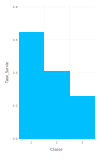

In [46]:
# Affichage du taux de survie des passagers en fonction de leur classe

df = combine(groupby(data, :Pclass), :Survived => mean => :Taux_Survie )

rename!(df, :Pclass => :Classe)
df = df[[1;3;2], :]

plot(df, x=:Classe, y=:Taux_Survie, Geom.bar)

In [47]:
df = combine(groupby(data, :Pclass),:Survived => length =>:Nombre,  :Survived => sum =>:Survivants)

Row,Pclass,Nombre,Survivants
,String,Int64,Int64
1,1,208,135
2,3,477,125
3,2,187,77


In [48]:
df.Morts = df.Nombre - df.Survivants
df = df[[1,3,2],:]

Row,Pclass,Nombre,Survivants,Morts
,String,Int64,Int64,Int64
1,1,208,135,73
2,2,187,77,110
3,3,477,125,352


# 3.2 Régression logistique

On utilise seulement la classe comme variable explicative dans le modèle linéaire généralisé.

In [49]:
# Encoder la classe des passagers avec deux variables indicatrices

Pclass = data.Pclass
n = length(Pclass)
x₁ = zeros(Int64,n)
x₂ = zeros(Int64,n)
for i = 1:n
    if Pclass[i]=="2"
        x₂[i] = 1
    elseif Pclass[i]=="1"
        x₁[i] = 1
    end   
end

y = data[:,:Survived]

X = hcat(ones(n), x₁, x₂)

# Stockage des variables du modèle dans un dataframe pour une utilisation simple de la librairie GLM
df = DataFrame(x₁=x₁, x₂=x₂, Y=y)
first(df, 5)

Row,x₁,x₂,Y
,Int64,Int64,Int64
1,1,0,1
2,0,0,0
3,0,1,1
4,0,0,0
5,0,0,0


## Estimation par maximum de la vraisemblance du modèle de régression logistique

1. La classe des passagers est utilisée comme variable explicative
2. La fonction de lien logit est utilisée

In [50]:
M = glm(@formula(Y ~ x₁ + x₂), df,  Bernoulli(), LogitLink())

#= Avec les valeurs p affichées, on constate que la classe possède un pouvoir prédictif significatif
pour prédire la survie des passagers. =#

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Bernoulli{Float64}, LogitLink}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + x₁ + x₂

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      z  Pr(>|z|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  -1.03532     0.10412   -9.94    <1e-22  -1.23939   -0.831247
x₁            1.65013     0.178737   9.23    <1e-19   1.29981    2.00045
x₂            0.678642    0.181435   3.74    0.0002   0.323036   1.03425
─────────────────────────────────────────────────────────────────────────

In [51]:
# Pour le modèle probit

# M = glm(@formula(Y ~ x₁ + x₂), df,  Bernoulli(), ProbitLink())

#= Avec les valeurs p affichées, on constate que la classe possède un pouvoir prédictif significatif
pour prédire la survie des passagers. =#

In [52]:
β̂ = coef(M)

3-element Vector{Float64}:
 -1.0353174382928505
  1.6501327755828328
  0.678642494354118

In [53]:
# Estimation de la probabilité de survie par classe

β̂ = coef(M)

x₀ = [1.0 1.0 0.0 ;
      1.0 0.0 1.0 ; 
      1.0 0.0 0.0]

θ̂₀ = predict(M,x₀)

3-element Vector{Float64}:
 0.6490384615384488
 0.4117647058823529
 0.2620545073380958

In [54]:
# Pour chacune des observations, estimation de la probabilité de survie

θ̂ = predict(M)

872-element Vector{Float64}:
 0.6490384615384488
 0.2620545073380958
 0.4117647058823529
 0.2620545073380958
 0.2620545073380958
 0.2620545073380958
 0.6490384615384488
 0.4117647058823529
 0.2620545073380958
 0.4117647058823529
 ⋮
 0.2620545073380958
 0.6490384615384488
 0.4117647058823529
 0.2620545073380958
 0.6490384615384488
 0.2620545073380958
 0.6490384615384488
 0.6490384615384488
 0.4117647058823529

In [55]:
Ŷ = zeros(Int64,length(θ̂))
Ŷ[θ̂.>1/2] .= 1
Ŷ

872-element Vector{Int64}:
 1
 0
 0
 0
 0
 0
 1
 0
 0
 0
 ⋮
 0
 1
 0
 0
 1
 0
 1
 1
 0

### Variables qualitatives avec GLM 

Lorsque la variable explicative est un string, GLM encode automatiquement les différentes
catégories avec des variables indicatrices. Pas besoin de le faire manuellement tel que présenté précédemment. L'effet de base (intercept) est définie par la première catégorie rencontrée dans le DataFrame.

In [56]:
# Pour que GLM considère la classe comme une variable qualitative
data[!, :Pclass] = string.(data[:, :Pclass])

M = glm(@formula(Survived ~ Pclass), data,  Bernoulli(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Bernoulli{Float64}, LogitLink}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Survived ~ 1 + Pclass

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      z  Pr(>|z|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)   0.614815    0.145279   4.23    <1e-04   0.330073   0.899557
Pclass: 2    -0.97149     0.207807  -4.67    <1e-05  -1.37879   -0.564195
Pclass: 3    -1.65013     0.178737  -9.23    <1e-19  -2.00045   -1.29981
─────────────────────────────────────────────────────────────────────────

# 3.2.3 Mesure de la qualité du modèle

Supposons que l'on prédit que le passager survit si θ̂ > 1/2 (règle de décision par défaut supposant que les classes sont balancées).

In [57]:
# Le taux de bonnes prédictions
ŷ = zeros(Int64,length(data.Survived))
ŷ[θ̂ .> 1/2] .= 1 

println("Le taux de bonnes prédictions est de ", round(correctrate(data.Survived, ŷ), digits=3),".")


Le taux de bonnes prédictions est de 0.685.


In [58]:
# Calcul du taux de vrais positifs et de faux positifs pour un seuil de 1/2.

r = roc(data.Survived, θ̂, 1/2)

println("La sensibilité est de ", round(recall(r), digits=3))
println("La spécificité est de ", round(true_negative_rate(r), digits=3))
println("Le score F1 est de ", round(f1score(r), digits=3))

La sensibilité est de 0.401
La spécificité est de 0.864
Le score F1 est de 0.495


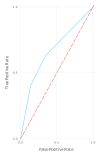

In [59]:
# Affichage de la courbe ROC

rocplot(data.Survived, θ̂)

# draw(PDF("roc.pdf", 4inch, 3inch), fig)

In [60]:
# Calcul de l'aire sous la courbe ROC

A = auc(data.Survived, θ̂)

0.6691061870822818

# Matériel supplémentaire

In [66]:
M = glm(@formula(Survived ~ Pclass + Sex + Age + Pclass*Sex+SibSp), data,  Bernoulli(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Bernoulli{Float64}, LogitLink}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Survived ~ 1 + Pclass + Sex + Age + SibSp + Pclass & Sex

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────
                            Coef.  Std. Error      z  Pr(>|z|)   Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────────────
(Intercept)             5.52075    0.742937     7.43    <1e-12   4.06462     6.97688
Pclass: 2              -1.78415    0.730362    -2.44    0.0146  -3.21563    -0.352666
Pclass: 3              -4.26421    0.666633    -6.40    <1e-09  -5.57079    -2.95763
Sex: male              -3.90965    0.637421    -6.13    <1e-09  -5.15897    -2.66033
Age                    -0.0454922  0.00893742  -5.09    <1e-06  -0.0630092  -0.0279752
SibSp            

In [67]:
df = DataFrame(Pclass="3", Sex="male", Age = 22)
predict(M, df)

ErrorException: type NamedTuple has no field SibSp

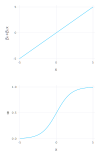

In [71]:
β₀ = 0.0
β₁ = 1.0

fig1 = plot(x -> β₀+β₁*x, -5, 5, Guide.ylabel("β₀+β₁x"))
fig2 = plot(x -> exp(β₀+β₁*x)/(1+exp(β₀+β₁*x)), -5, 5, Guide.ylabel("θ"))

set_default_plot_size(10cm, 16cm)
vstack(fig1, fig2)

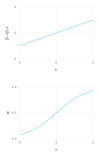

In [72]:
β₀ = 0.0
β₁ = .5

fig3 = plot(x -> β₀+β₁*x, -5, 5, Guide.ylabel("β₀+β₁x"), Coord.cartesian(ymin=-5, ymax=5))
fig4 = plot(x -> exp(β₀+β₁*x)/(1+exp(β₀+β₁*x)), -5, 5, Guide.ylabel("θ"), Coord.cartesian(ymin=-0, ymax=1))

set_default_plot_size(10cm, 16cm)
vstack(fig3, fig4)

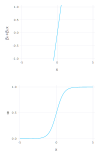

In [73]:
β₀ = 0.0
β₁ = 2.0

fig5 = plot(x -> β₀+β₁*x, -5, 5, Guide.ylabel("β₀+β₁x"), Coord.cartesian(ymin=-1, ymax=1))
fig6 = plot(x -> exp(β₀+β₁*x)/(1+exp(β₀+β₁*x)), -5, 5, Guide.ylabel("θ"), Coord.cartesian(ymin=-0, ymax=1))

set_default_plot_size(10cm, 16cm)
vstack(fig5, fig6)